## Interpreting abundances with chempy

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [3]:
data = Table.read('../data/STs_for_chempy.fits', format='fits')
el_names = data.colnames[3::2] # magic
err_names = data.colnames[4::2]

#### load up Jan's Solar abundances:

In [4]:
x = np.load("../data/[2]posterior_100_Sun-predictions.npy")
y = np.load("../data/[3]predicted_element_names.npy")
for i,item in enumerate(y):
    print(item,np.median(x[:,i]),'+-',np.std(x[:,i]))

Fe -0.05236939885020275 +- 0.061973267953103796
O 0.14124797676453404 +- 0.07958465573507391
Na 0.2703209968721536 +- 0.07845643376718812
Mg 0.025945304509467526 +- 0.07041198047974788
Al 0.11384539100839808 +- 0.08147465702227544
Si 0.21571735741698372 +- 0.037009385325165914
S 0.19014242128613423 +- 0.039907886691498966
Ca 0.00883028042476841 +- 0.04411411675457362
V -0.16723689314414703 +- 0.02841648899149541
Mn 0.11060540169168309 +- 0.03927567799253105
Co -0.06394600865761602 +- 0.06060708205475778
Ni 0.2165610291078881 +- 0.025279463574813043
Cu -0.10756046441771971 +- 0.10607712986082651
Zn -0.2513681328253119 +- 0.07967744528596993
C 0.057576876578344205 +- 0.06783522714011568
Ti -0.17631813386302841 +- 0.04299903911234888
Sc -0.34388003870911454 +- 0.10127600441322712
Cr 0.07789504160256833 +- 0.010311644615551785


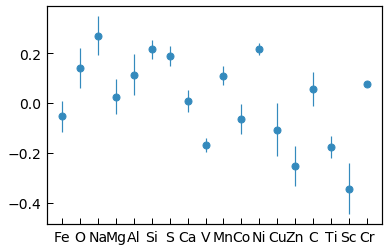

In [5]:
plt.errorbar(np.arange(len(y)), np.median(x, axis=0), yerr=np.std(x, axis=0), fmt='o')
plt.xticks(np.arange(len(y)), y);

#### now make a new dataset having propagated the Solar offsets through:

In [6]:
el_to_delete = np.asarray(el_names)[~np.isin(el_names, y)]

In [7]:
data.remove_columns(el_to_delete)

In [8]:
data.remove_columns(['{0}_err'.format(e) for e in el_to_delete])

In [9]:
for i,item in enumerate(y):
    data[item] += np.median(x[:,i])

In [10]:
data.write('../data/STs_chempy_sun_adjusted.fits', overwrite=True)

#### look at Jan's fits to solar twins

In [11]:
# go back to original abundances
for i,item in enumerate(y):
    data[item] -= np.median(x[:,i])

In [12]:
data['O']

0.023999999999999994
-0.06899999999999999
0.021999999999999992
0.05099999999999999
-0.022999999999999993
-0.015999999999999986
-0.0050000000000000044
0.14300000000000002
0.05499999999999999
0.123
nan


In [13]:
import copy
chempy_data = copy.deepcopy(data)

In [14]:
x = np.load("../data/posterior_elemental_abundances/{0}_posterior_100_blobs.npy".format(0))

In [15]:
y = np.load("../data/posterior_elemental_abundances/blobs_elements.npy")
for i in range(len(chempy_data)):
    try:
        x = np.load("../data/posterior_elemental_abundances/{0}_posterior_100_blobs.npy".format(i))
        abunds = np.median(x, axis=0)
        for el,ab in zip(y,abunds):
            chempy_data[i][el] = ab
    except:
        print("star {0} not found".format(i))

star 10 not found


In [18]:
def pca(data_table):
    N = len(data_table) # will be over-written
    D = len(y)
    data1 = np.zeros((N, D))
    data1_err = np.zeros((N, D))
    for d, spn in enumerate(y):
        data1[:, d] = np.asarray(data_table[spn])
        data1_err[:, d] = np.asarray(data_table[spn+'_err'])
        
    # FOR NOW: remove one bad object -- HACK
    good = np.isfinite(data1)
    bad = ~good
    mask = np.sum(bad, axis=1) == 0
    data1 = data1[mask] # remove one star with one missing abundance
    data1_err = data1_err[mask]
    N, D = data1.shape # over-write
    
    mean = np.mean(data1, axis=0)
    dd = data1 - mean[None, :]
    u, s, vecs = np.linalg.svd(dd, full_matrices=False)
    amps = u * s[None, :]
    # reconstruction = mean[None, :] + np.dot(pcas, v)
    # print(data - reconstruction)
    return vecs, amps

In [19]:
data_vecs, data_amps = pca(data)
data_eigenvals = np.sum(data_amps * data_amps, axis=0)
chempy_vecs, chempy_amps = pca(chempy_data)
chempy_eigenvals = np.sum(chempy_amps * chempy_amps, axis=0)

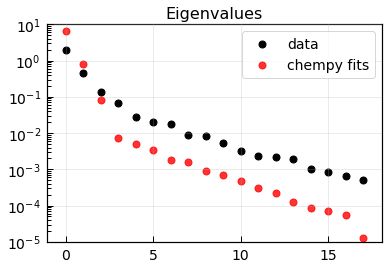

In [24]:
plt.scatter(np.arange(len(data_eigenvals)), data_eigenvals, color="k", label='data')
plt.scatter(np.arange(len(chempy_eigenvals)), chempy_eigenvals, color="r", alpha=0.8, label='chempy fits')
plt.semilogy()
plt.ylim(1.e-5, 10.)
plt.grid(alpha=0.3)
plt.title('Eigenvalues', fontsize=16)
plt.legend(fontsize=14)
#plt.savefig('eigenvals.png')